In [ ]:
!pip install numpy matplotlib pandas

In [ ]:
# Get plot data

import json
def getPlotData(fileName, data_type):
    with open(fileName, 'r') as file:
        data_all_a = json.load(file)

    y_x_a = []
    if data_type=='m_unc':
        for data in data_all_a:
            total = float(data["Packets"]["Unconfirmed"])
            success = float(data["Packets"]["UnconfirmedSuccess"])
            if total>0:
                d = (success/total,total/float(data["SimTime"]))
                y_x_a.append(d)
    elif data_type=='m_c':
        for data in data_all_a:
            total = float(data["Packets"]["Confirmed"])
            success = float(data["Packets"]["ConfirmedSuccess"])
            if total>0:
                d = (success/total,total/float(data["SimTime"]))
                y_x_a.append(d)
    elif data_type=='cpsr':
        for data in data_all_a:
            total = float(data["CPSR"]["Total"])
            success = float(data["CPSR"]["Success"])
            if total>0:
                d = (success/total,total/float(data["SimTime"]))
                y_x_a.append(d)
    elif data_type=='saturated_gw':
        for data in data_all_a:
            total = float(data['Metrics']['S']) + float(data['Metrics']['U']) + float(data['Metrics']['I']) + float(data['Metrics']['R']) + float(data['Metrics']['T'])
            success = float(data["Metrics"]["R"])
            total_packets = float(data["ULPDR"]["Total"])
            if total > 0:
                d = (success/total,total_packets/float(data["SimTime"]))
                y_x_a.append(d)
    else:
        for data in data_all_a:
            d = (float(data["ULPDR"]["Success"])/float(data["ULPDR"]["Total"]),float(data["ULPDR"]["Total"])/float(data["SimTime"]))
            y_x_a.append(d)

    y_x_a.sort(key=lambda x: x[1])

    y = [d[0] for d in y_x_a]
    x = [d[1] for d in y_x_a]
    return x,y

In [ ]:
# Filter using z-scores

import numpy as np

def find_outliers_zscore(x, y, l_threshold=0.1, h_threshold=5):

    x = np.array(x)
    y = np.array(y)

    z_scores_y = np.abs((y - np.mean(y)) / np.std(y))

    filtered_indices = np.where((z_scores_y > l_threshold) & (z_scores_y < h_threshold))[0]
    filtered = [(x[i], y[i]) for i in filtered_indices]

    return filtered


<b><ul><li>Polynomial Fit, no filtering</b>

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def create_plot(fileNamex, labelx, mixed_type, degree, line_style, marker_style):
    x,y = getPlotData(fileNamex, mixed_type)

    plt.xscale('log')

    df = pd.DataFrame({"X Values": x, "Y Values": y})
    
    coefficients = np.polyfit(df['X Values'], df['Y Values'], degree)
    polynomial = np.poly1d(coefficients)
    df['y_fitted'] = polynomial(df['X Values'])

    plt.plot(df['X Values'], df['y_fitted'], label=f'{labelx}', linestyle=line_style, marker=marker_style, color='black', markerfacecolor='None')

    plt.legend()

<h1>Class B devices</h1>
<hr><hr><hr><h3><li>1. Baseline Performance Analysis</li></h3><hr><hr><hr>

In [ ]:
# Create plot for class b baseline analysis

create_plot('final_sim/test_scenario_baseline/True/ULPDR_UNCONFIRMED_B', 'Unconfirmed-only traffic, class B','unc',7,'-','o')
create_plot('final_sim/test_scenario_baseline/True/ULPDR_CONFIRMED_B', 'Confirmed-only traffic, class B','unc',7,'-','x')
create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_B', 'Mixed traffic, unconfirmed, class B','m_unc',7,':','o')
create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_B', 'Mixed traffic, confirmed, class B','m_c',7,':','x')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,2])
plt.ylim([0.8,1])

plt.grid(True, which='both')

plt.savefig('svg_plots/class_b_baseline_ulpdr.svg', format='svg')
plt.show()


create_plot('final_sim/test_scenario_baseline/True/ULPDR_UNCONFIRMED_C', 'Unconfirmed-only traffic, class C','unc',7,'-','o')
create_plot('final_sim/test_scenario_baseline/True/ULPDR_CONFIRMED_C', 'Confirmed-only traffic, class C','unc',7,'-','x')
create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_C', 'Mixed traffic, unconfirmed, class C','m_unc',7,':','o')
create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_C', 'Mixed traffic, confirmed, class C','m_c',7,':','x')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,2])
plt.ylim([0.8,1])

plt.grid(True, which='both')

plt.savefig('svg_plots/class_c_baseline_ulpdr.svg', format='svg')
plt.show()

In [ ]:

import matplotlib.pyplot as plt
import json

def get_bar_plot_data(fileName):
    with open(fileName, 'r') as file:
        data_all_a = json.load(file)
        s_count=0
        u_count=0
        i_count=0
        r_count=0
        t_count=0
        for data in data_all_a:
            s_count += float(data['Metrics']['S'])
            u_count += float(data['Metrics']['U'])
            i_count += float(data['Metrics']['I'])
            r_count += float(data['Metrics']['R'])
            t_count += float(data['Metrics']['T'])
        total = u_count+i_count+r_count+t_count
        y = [(u_count/total), (i_count/total), (r_count/total), (t_count/total)]
        
        return y

def generate_bar_plot(unc_file1, cn_file2, device_class):
    x = ['U', 'I', 'R', 'T']
    ulpdr_unconfirmed = get_bar_plot_data(unc_file1)
    ulpdr_confirmed = get_bar_plot_data(cn_file2)

    plt.figure(figsize=(5, 2.5))

    bar_width = 0.9

    bar_positions_set1= [2,6,10,14]
    bar_positions_set2= [3,7,11,15]

    plt.bar(bar_positions_set1, ulpdr_unconfirmed, width=bar_width, label='Unconfirmed', color='white', edgecolor='black', hatch='\\\\\\')
    plt.bar(bar_positions_set2, ulpdr_confirmed, width=bar_width, label='confirmed', color='white',edgecolor='black', hatch='...')

    # Add labels to the axes
    plt.ylabel('Fraction of lost packets (%)')
    # plt.title(f'Class {device_class}')

    xtick_positions = [2.5, 6.5, 10.5, 14.5] 
    plt.xticks(xtick_positions, x)

    plt.legend()
    plt.ylim([0.0,1.0])
    # plt.tight_layout()
    
    plt.grid(True, which='both')
    

In [ ]:
# Create bar plot for lost packets
generate_bar_plot('final_sim/test_scenario_baseline/True/ULPDR_UNCONFIRMED_B', 'final_sim/test_scenario_baseline/True/ULPDR_CONFIRMED_B', 'B')
plt.savefig('svg_plots/class_b_baseline_fraction_lost_packets.svg', format='svg')
plt.show()

generate_bar_plot('final_sim/test_scenario_baseline/True/ULPDR_UNCONFIRMED_C', 'final_sim/test_scenario_baseline/True/ULPDR_CONFIRMED_C', 'C')
plt.savefig('svg_plots/class_c_baseline_fraction_lost_packets.svg', format='svg')
plt.show()

<hr><hr><hr><h3><li>2. Gateway DC</li></h3></ol><hr><hr><hr>

<p>Duty cycle on/off doesn't have any impact on UL-PDR performance of Class B and Class C devices</p>

In [ ]:

create_plot('final_sim/test_scenario_gw_dc_on_off/on/ULPDR_UNCONFIRMED_B', 'Baseline, class B', 'unc', 7, '-', 'x')
create_plot('final_sim/test_scenario_gw_dc_on_off/off/ULPDR_UNCONFIRMED_B', 'GW DC off, Class B', 'unc', 7, '--', 'x')

# create_plot('final_sim/test_scenario_gw_dc_on_off/on/ULPDR_CONFIRMED_B', 'Baseline, class B', 'cpsr', 7, '-', 'x')
# create_plot('final_sim/test_scenario_gw_dc_on_off/off/ULPDR_CONFIRMED_B', 'GW DC off, Class B', 'cpsr', 7, '--', 'x')

# create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_CONFIRMED_B', 'GW RX priority, Class B', 'cpsr', 7, ':', 'x')

create_plot('final_sim/test_scenario_gw_dc_on_off/on/ULPDR_UNCONFIRMED_C', 'Baseline, class C', 'unc', 7, '-', 'o')
create_plot('final_sim/test_scenario_gw_dc_on_off/off/ULPDR_UNCONFIRMED_C', 'GW DC off, Class C', 'unc', 7, '--', 'o')

# create_plot('final_sim/test_scenario_gw_dc_on_off/on/ULPDR_CONFIRMED_C', 'Baseline, class C', 'cpsr', 7, '-', 'o')
# create_plot('final_sim/test_scenario_gw_dc_on_off/off/ULPDR_CONFIRMED_C', 'GW DC off, Class C', 'cpsr', 7, '--', 'o')
# create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_CONFIRMED_C', 'GW RX priority, Class C', 'cpsr', 7, ':', 'o')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')  
plt.xlim([0.01,1])
plt.ylim([0.6,1.0])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_b_c_cpsr_dc_rx.svg', format='svg')
plt.show()

In [ ]:
# Create bar plot for lost packets


generate_bar_plot('final_sim/test_scenario_gw_dc_on_off/off/ULPDR_UNCONFIRMED_B', 'final_sim/test_scenario_gw_dc_on_off/off/ULPDR_CONFIRMED_B', 'B')
plt.savefig('svg_plots/class_b_dc_off_fraction_lost_packets.svg', format='svg')
plt.show()

generate_bar_plot('final_sim/test_scenario_gw_dc_on_off/off/ULPDR_UNCONFIRMED_C', 'final_sim/test_scenario_gw_dc_on_off/off/ULPDR_CONFIRMED_C', 'C')
plt.savefig('svg_plots/class_c_dc_off_fraction_lost_packets.svg', format='svg')
plt.show()

<hr><hr><hr><h3><li>3. Priority of Reception Over Transmission</li></h3></ol><hr><hr><hr>

In [ ]:
# Create plot for class b Rx priority analysis

create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_CONFIRMED_B', 'Conf., TX prioritization class B','unc',2,'-','D')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_CONFIRMED_B', 'Conf., RX prioritization class B','unc',2,'--','D')
create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_MIXED_B', 'Mixed Unconf., TX prioritization class B','m_unc',5,'-','o')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_MIXED_B', 'Mixed Unconf., RX prioritization class B','m_unc',5,'--','o')
create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_MIXED_B', 'Mixed conf., TX prioritization class B','m_c',2,'-','x')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_MIXED_B', 'Mixed conf., RX prioritization class B','m_c',2,'--','x')

f = plt.gcf()
f.set_figwidth(5)
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,1])
plt.ylim([0.86,1.0])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_b_gw_tx_priority_ulpdr.svg', format='svg')

line1_data = plt.gca().get_lines()[2].get_data()
line2_data = plt.gca().get_lines()[3].get_data()


# Calculate the percentage change for each corresponding pair of data points
percentage_changes = [(line2_data[1][i] - line1_data[1][i]) / line1_data[1][i] * 100 for i in range(len(line1_data[1]))]

# Find the minimum and maximum percentage change values
min_percentage_change = min(percentage_changes)
max_percentage_change = max(percentage_changes)

# Find the indices of the min and max percentage changes
min_index = percentage_changes.index(min_percentage_change)
max_index = percentage_changes.index(max_percentage_change)

# Print the data points for the highest and lowest percentage changes
print("Data point for lowest percentage change ({}%): x={}, y1={}, y2={}".format(
    min_percentage_change, line1_data[0][min_index], line1_data[1][min_index], line2_data[1][min_index]))
print("Data point for highest percentage change ({}%): x={}, y1={}, y2={}".format(
    max_percentage_change, line1_data[0][max_index], line1_data[1][max_index], line2_data[1][max_index]))

plt.show()

create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_CONFIRMED_B', 'Conf., TX prioritization, class B','cpsr',7,'-','D')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_CONFIRMED_B', 'Conf., RX prioritization, class B','cpsr',7,'--','D')
# 
create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_CONFIRMED_C', 'Conf., TX prioritization, class C','cpsr',7,'-','o')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_CONFIRMED_C', 'Conf., RX prioritization, class C','cpsr',7,'--','o')
create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_MIXED_B', 'Mixed conf., TX prioritization, class B','cpsr',7,'-','x')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_MIXED_B', 'Mixed conf., RX prioritization, class B','cpsr',7,'--','x')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,0.36])
plt.ylim([0.43,1.0])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_b_c_gw_tx_priority_cpsr.svg', format='svg')
plt.show()

In [ ]:
# Create plot for class b Rx priority analysis


create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_CONFIRMED_C', 'Conf., TX prioritization class C','unc',2,'-','D')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_CONFIRMED_C', 'Conf., RX prioritization class C','unc',2,'--','D')
create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_MIXED_C', 'Mixed Unconf., TX prioritization class C','m_unc',5,'-','o')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_MIXED_C', 'Mixed Unconf., RX prioritization class C','m_unc',5,'--','o')
create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_MIXED_C', 'Mixed conf., TX prioritization class C','m_c',2,'-','x')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_MIXED_C', 'Mixed conf., RX prioritization class C','m_c',2,'--','x')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,0.5])
plt.ylim([0.8,1.0])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_c_gw_tx_priority_ulpdr.svg', format='svg')
plt.show()

create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_CONFIRMED_C', 'Conf., TX prioritization class C','cpsr',7,'-','D')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_CONFIRMED_C', 'Conf., RX prioritization class C','cpsr',7,'--','D')
create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_MIXED_C', 'Mixed conf., TX prioritization class C','cpsr',7,'-','x')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_MIXED_C', 'Mixed conf., RX prioritization class C','cpsr',7,'--','x')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,0.26])
plt.ylim([0.8,1.0])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_c_gw_tx_priority_cpsr.svg', format='svg')
plt.show()

In [ ]:
# Create bar plot for lost packets


generate_bar_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_CONFIRMED_C', 'final_sim/test_scenario_gw_tx_priority/False/ULPDR_CONFIRMED_C', 'C')
plt.savefig('svg_plots/class_b_dc_off_fraction_lost_packets.svg', format='svg')
plt.show()

# generate_bar_plot('final_sim/test_scenario_gw_dc_on_off/off/ULPDR_UNCONFIRMED_C', 'final_sim/test_scenario_gw_dc_on_off/off/ULPDR_CONFIRMED_C', 'C')
# plt.savefig('svg_plots/class_c_dc_off_fraction_lost_packets.svg', format='svg')
# plt.show()

<hr><hr><hr><h3><li>4. Number of Transmission Attempts</li></h3></ol><hr><hr><hr>

In [ ]:
# Create plot for class b change of transmission attempts analysis

create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_CONFIRMED_B', 'Conf., class B, m=2','unc',7,'-','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_CONFIRMED_B', 'Conf., class B, m=4','unc',7,'--','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/6/ULPDR_CONFIRMED_B', 'Conf., class B, m=6','unc',7,':','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_CONFIRMED_B', 'Conf., class B, m=8','unc',7,':','D')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/10/ULPDR_CONFIRMED_B', 'Conf., class B, m=10','unc',7,'-','D')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/12/ULPDR_CONFIRMED_B', 'Conf., class B, m=12','unc',7,'--','D')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/14/ULPDR_CONFIRMED_B', 'Conf., class B, m=14','unc',7,':','o')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/16/ULPDR_CONFIRMED_B', 'Conf., class B, m=16','unc',7,'--','x')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/32/ULPDR_CONFIRMED_B', 'Conf., class B, m=32','unc',7,':','x')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 1.4])
plt.ylim([0.95,1])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_b_retransmission_attempts_ulpdr.svg', format='svg')
plt.show()





create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_MIXED_B', 'Mixed UnConf., class B, m=2','m_unc',5,'-','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_MIXED_B', 'Mixed UnConf., class B, m=4','m_unc',5,'--','o')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/6/ULPDR_MIXED_B', 'Mixed UnConf., class B, m=6','m_unc',5,':','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_MIXED_B', 'Mixed UnConf., class B, m=8','m_unc',5,'--','D')

create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_MIXED_B', 'Mixed Conf., class B, m=2','m_c',2,'-','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_MIXED_B', 'Mixed Conf., class B, m=4','m_c',2,'--','x')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/6/ULPDR_MIXED_B', 'Mixed Conf., class B, m=6','m_c',2,':','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_MIXED_B', 'Mixed Conf., class B, m=8','m_c',2,':','D')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/10/ULPDR_MIXED_B', 'Mixed Conf., class B, m=10','m_c',7,'-','D')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/12/ULPDR_MIXED_B', 'Mixed Conf., class B, m=12','m_c',7,'--','D')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/14/ULPDR_CONFIRMED_B', 'Conf., class B, m=14','unc',7,':','o')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/16/ULPDR_CONFIRMED_B', 'Conf., class B, m=16','unc',7,'--','x')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/32/ULPDR_CONFIRMED_B', 'Conf., class B, m=32','unc',7,':','x')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 1.4])
plt.ylim([0.75,1])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_b_retransmission_attempts_ulpdr_mixed.svg', format='svg')
plt.show()



create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_MIXED_B', 'Mixed Conf., class B, m=2','cpsr',5,'-','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_MIXED_B', 'Mixed Conf., class B, m=4','cpsr',5,'--','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/6/ULPDR_MIXED_B', 'Mixed Conf., class B, m=6','cpsr',5,':','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_MIXED_B', 'Mixed Conf., class B, m=8','cpsr',5,':','D')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 1.4])
plt.ylim([0.75,1])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_b_retransmission_attempts_cpsr_mixed.svg', format='svg')
plt.show()







create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_CONFIRMED_B', 'Conf., class B, m=2','cpsr',7,'-','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_CONFIRMED_B', 'Conf., class B, m=4','cpsr',7,'--','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/6/ULPDR_CONFIRMED_B', 'Conf., class B, m=6','cpsr',7,'-','D')

create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_CONFIRMED_B', 'Conf., class B, m=8','cpsr',7,':','D')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/10/ULPDR_CONFIRMED_B', 'Conf., class B, m=10','cpsr',7,'--','D')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/12/ULPDR_CONFIRMED_B', 'Conf., class B, m=12','cpsr',7,'-','o')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/14/ULPDR_CONFIRMED_B', 'Conf., class B, m=14','cpsr',7,'-','x')

# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/16/ULPDR_CONFIRMED_B', 'Conf., class B, m=16','cpsr',7,'--','x')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/32/ULPDR_CONFIRMED_B', 'Conf., class B, m=32','cpsr',7,':','x')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 1.4])
plt.ylim([0.3,1])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_b_retransmission_attempts_cpsr.svg', format='svg')
plt.show()


In [ ]:
# Create plot for class b change of transmission attempts analysis

create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_CONFIRMED_C', 'Conf., class C, m=2','unc',7,'-','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_CONFIRMED_C', 'Conf., class C, m=4','unc',7,'--','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/6/ULPDR_CONFIRMED_C', 'Conf., class C, m=6','unc',7,':','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_CONFIRMED_C', 'Conf., class C, m=8','unc',7,':','D')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/10/ULPDR_CONFIRMED_C', 'Conf., class C, m=10','unc',7,'-','D')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/12/ULPDR_CONFIRMED_C', 'Conf., class C, m=12','unc',7,'--','D')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/14/ULPDR_CONFIRMED_C', 'Conf., class B, m=14','unc',7,':','o')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/16/ULPDR_CONFIRMED_C', 'Conf., class B, m=16','unc',7,'--','x')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/32/ULPDR_CONFIRMED_C', 'Conf., class B, m=32','unc',7,':','x')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 1.4])
plt.ylim([0.95,1])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_c_retransmission_attempts_ulpdr.svg', format='svg')
plt.show()



create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_MIXED_C', 'Mixed UnConf., class C, m=2','m_unc',5,'-','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_MIXED_C', 'Mixed UnConf., class C, m=4','m_unc',5,'--','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/6/ULPDR_MIXED_C', 'Mixed UnConf., class C, m=6','m_unc',5,':','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_MIXED_C', 'Mixed UnConf., class C, m=8','m_unc',5,'--','D')

create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_MIXED_C', 'Mixed Conf., class C, m=2','m_c',2,'-','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_MIXED_C', 'Mixed Conf., class C, m=4','m_c',2,'--','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/6/ULPDR_MIXED_C', 'Mixed Conf., class C, m=6','m_c',2,':','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_MIXED_C', 'Mixed Conf., class C, m=8','m_c',2,':','D')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/10/ULPDR_MIXED_B', 'Mixed Conf., class B, m=10','m_c',7,'-','D')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/12/ULPDR_MIXED_B', 'Mixed Conf., class B, m=12','m_c',7,'--','D')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/14/ULPDR_CONFIRMED_B', 'Conf., class B, m=14','unc',7,':','o')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/16/ULPDR_CONFIRMED_B', 'Conf., class B, m=16','unc',7,'--','x')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/32/ULPDR_CONFIRMED_B', 'Conf., class B, m=32','unc',7,':','x')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 1.4])
plt.ylim([0.75,1])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_c_retransmission_attempts_ulpdr_mixed.svg', format='svg')
plt.show()



# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_MIXED_C', 'Mixed UnConf., class C, m=2','m_unc',5,'-','o')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_MIXED_C', 'Mixed UnConf., class C, m=4','m_unc',5,'--','o')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/6/ULPDR_MIXED_B', 'Mixed UnConf., class B, m=6','m_unc',5,':','o')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_MIXED_C', 'Mixed UnConf., class C, m=8','m_unc',5,'--','D')

# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/10/ULPDR_MIXED_B', 'Mixed Conf., class B, m=10','m_c',7,'-','D')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/12/ULPDR_MIXED_B', 'Mixed Conf., class B, m=12','m_c',7,'--','D')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/14/ULPDR_CONFIRMED_B', 'Conf., class B, m=14','unc',7,':','o')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/16/ULPDR_CONFIRMED_B', 'Conf., class B, m=16','unc',7,'--','x')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/32/ULPDR_CONFIRMED_B', 'Conf., class B, m=32','unc',7,':','x')



create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_MIXED_C', 'Mixed Conf., class C, m=2','cpsr',5,'-','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_MIXED_C', 'Mixed Conf., class C, m=4','cpsr',5,'--','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/6/ULPDR_MIXED_C', 'Mixed Conf., class C, m=6','cpsr',5,':','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_MIXED_C', 'Mixed Conf., class C, m=8','cpsr',5,':','D')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 1.4])
plt.ylim([0.75,1])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_c_retransmission_attempts_cpsr_mixed.svg', format='svg')
plt.show()




create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_CONFIRMED_C', 'Conf., class C, m=2','cpsr',7,'-','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_CONFIRMED_C', 'Conf., class C, m=4','cpsr',7,'--','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/6/ULPDR_CONFIRMED_C', 'Conf., class C, m=6','cpsr',7,'-','D')

create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_CONFIRMED_C', 'Conf., class C, m=8','cpsr',7,':','D')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/10/ULPDR_CONFIRMED_C', 'Conf., class C, m=10','cpsr',7,'--','D')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/12/ULPDR_CONFIRMED_C', 'Conf., class C, m=12','cpsr',7,'-','o')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/14/ULPDR_CONFIRMED_B', 'Conf., class B, m=14','cpsr',7,'-','x')

# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/16/ULPDR_CONFIRMED_B', 'Conf., class B, m=16','cpsr',7,'--','x')
# create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/32/ULPDR_CONFIRMED_B', 'Conf., class B, m=32','cpsr',7,':','x')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 1.4])
plt.ylim([0.3,1])

plt.grid(True, which='both')
plt.savefig('svg_plots/class_c_retransmission_attempts_cpsr.svg', format='svg')
plt.show()


<hr><hr><hr><h3><li>5. Number of Available Receive Paths</li></h3></ol><hr><hr><hr>

In [ ]:
# Create plot for class b change of transmission attempts analysis


create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=1','unc',7,'-','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=2','unc',7,'--','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=3','unc',7,':','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=4','unc',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=8','unc',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=16','unc',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=32','unc',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=64','unc',7,'--','D')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 5])
plt.ylim([0.8,1])
# plt.tight_layout()

plt.grid(True, which='both')

plt.savefig('svg_plots/class_b_gw_parallel_paths_unconf.svg', format='svg')
plt.show()



create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_CONFIRMED_B', 'Conf., class B, n=1','unc',7,'-','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_CONFIRMED_B', 'Conf., class B, n=2','unc',7,'--','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_CONFIRMED_B', 'Conf., class B, n=3','unc',7,':','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_CONFIRMED_B', 'Conf., class B, n=4','unc',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_CONFIRMED_B', 'Conf., class B, n=8','unc',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_CONFIRMED_B', 'Conf., class B, n=16','unc',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_CONFIRMED_B', 'Conf., class B, n=32','unc',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_CONFIRMED_B', 'Conf., class B, n=64','unc',7,'--','D')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 5])
plt.ylim([0.8,1])
# plt.tight_layout()

plt.grid(True, which='both')

plt.savefig('svg_plots/class_b_gw_parallel_paths_conf.svg', format='svg')
plt.show()




create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_CONFIRMED_B', 'Conf., class B, n=1','cpsr',7,'-','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_CONFIRMED_B', 'Conf., class B, n=2','cpsr',7,'--','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_CONFIRMED_B', 'Conf., class B, n=3','cpsr',7,':','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_CONFIRMED_B', 'Conf., class B, n=4','cpsr',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_CONFIRMED_B', 'Conf., class B, n=8','cpsr',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_CONFIRMED_B', 'Conf., class B, n=16','cpsr',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_CONFIRMED_B', 'Conf., class B, n=32','cpsr',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_CONFIRMED_B', 'Conf., class B, n=64','cpsr',7,'--','D')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 0.1])
plt.ylim([0.8,1])
# plt.tight_layout()

plt.grid(True, which='both')

# plt.savefig('svg_plots/class_b_gw_parallel_paths_cpsr.svg', format='svg')
plt.show()









create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_MIXED_B', 'Mixed UnConf., class B, n=4','m_unc',7,'-','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_MIXED_B', 'Mixed UnConf., class B, n=8','m_unc',7,'--','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_MIXED_B', 'Mixed UnConf., class B, n=16','m_unc',7,':','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_MIXED_B', 'Mixed UnConf., class B, n=32','m_unc',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_MIXED_B', 'Mixed Conf., class B, n=4','m_c',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_MIXED_B', 'Mixed Conf., class B, n=8','m_c',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_MIXED_B', 'Mixed Conf., class B, n=16','m_c',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_MIXED_B', 'Mixed Conf., class B, n=32','m_c',7,'--','D')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 5])
plt.ylim([0.8,1])
# plt.tight_layout()

plt.grid(True, which='both')

plt.savefig('svg_plots/class_b_gw_parallel_paths_mixed.svg', format='svg')
plt.show()












create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=1','saturated_gw',7,'-','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=2','saturated_gw',7,'--','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=3','saturated_gw',7,':','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=4','saturated_gw',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=8','saturated_gw',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=16','saturated_gw',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=32','saturated_gw',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_UNCONFIRMED_B', 'UnConf., class B, n=64','saturated_gw',7,'--','D')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('Fraction of lost packets due to R (%)')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 8])
plt.ylim([0.0,0.9])
# plt.tight_layout()

plt.grid(True, which='both')

plt.savefig('svg_plots/class_b_gw_parallel_paths_fraction_of_lost_packets_r_unconf.svg', format='svg')
plt.show()




create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_CONFIRMED_B', 'Conf., class B, n=1','saturated_gw',7,'-','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_CONFIRMED_B', 'Conf., class B, n=2','saturated_gw',7,'--','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_CONFIRMED_B', 'Conf., class B, n=3','saturated_gw',7,':','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_CONFIRMED_B', 'Conf., class B, n=4','saturated_gw',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_CONFIRMED_B', 'Conf., class B, n=8','saturated_gw',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_CONFIRMED_B', 'Conf., class B, n=16','saturated_gw',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_CONFIRMED_B', 'Conf., class B, n=32','saturated_gw',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_CONFIRMED_B', 'Conf., class B, n=64','saturated_gw',7,'--','D')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('Fraction of lost packets due to R (%)')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 8])
plt.ylim([0.0,0.9])
# plt.tight_layout()

plt.grid(True, which='both')

plt.savefig('svg_plots/class_b_gw_parallel_paths_fraction_of_lost_packets_r_conf.svg', format='svg')
plt.show()


In [ ]:
# Create plot for class c change of transmission attempts analysis


create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=1','unc',7,'-','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=2','unc',7,'--','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=3','unc',7,':','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=4','unc',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=8','unc',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=16','unc',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=32','unc',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=64','unc',7,'--','D')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 5])
plt.ylim([0.8,1])
# plt.tight_layout()

plt.grid(True, which='both')
plt.savefig('svg_plots/class_c_gw_parallel_paths_unconf.svg', format='svg')
plt.show()



create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_CONFIRMED_C', 'Conf., class C, n=1','unc',7,'-','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_CONFIRMED_C', 'Conf., class C, n=2','unc',7,'--','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_CONFIRMED_C', 'Conf., class C, n=3','unc',7,':','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_CONFIRMED_C', 'Conf., class C, n=4','unc',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_CONFIRMED_C', 'Conf., class C, n=8','unc',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_CONFIRMED_C', 'Conf., class C, n=16','unc',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_CONFIRMED_C', 'Conf., class C, n=32','unc',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_CONFIRMED_C', 'Conf., class C, n=64','unc',7,'--','D')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 5])
plt.ylim([0.8,1])
# plt.tight_layout()

plt.grid(True, which='both')

plt.savefig('svg_plots/class_c_gw_parallel_paths_conf.svg', format='svg')
plt.show()




create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_CONFIRMED_C', 'Conf., class C, n=1','cpsr',7,'-','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_CONFIRMED_C', 'Conf., class C, n=2','cpsr',7,'--','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_CONFIRMED_C', 'Conf., class C, n=3','cpsr',7,':','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_CONFIRMED_C', 'Conf., class C, n=4','cpsr',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_CONFIRMED_C', 'Conf., class C, n=8','cpsr',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_CONFIRMED_C', 'Conf., class C, n=16','cpsr',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_CONFIRMED_C', 'Conf., class C, n=32','cpsr',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_CONFIRMED_C', 'Conf., class C, n=64','cpsr',7,'--','D')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 5])
plt.ylim([0.8,1])
# plt.tight_layout()

plt.grid(True, which='both')
plt.show()

plt.savefig('svg_plots/class_c_gw_parallel_paths.svg', format='svg')





create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_MIXED_C', 'Mixed UnConf., class C, n=4','m_unc',7,'-','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_MIXED_C', 'Mixed UnConf., class C, n=8','m_unc',7,'--','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_MIXED_C', 'Mixed UnConf., class C, n=16','m_unc',7,':','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_MIXED_C', 'Mixed UnConf., class C, n=32','m_unc',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_MIXED_C', 'Mixed Conf., class C, n=4','m_c',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_MIXED_C', 'Mixed Conf., class C, n=8','m_c',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_MIXED_C', 'Mixed Conf., class C, n=16','m_c',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_MIXED_C', 'Mixed Conf., class C, n=32','m_c',7,'--','D')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 5])
plt.ylim([0.8,1])
# plt.tight_layout()

plt.grid(True, which='both')

plt.savefig('svg_plots/class_c_gw_parallel_paths_mixed.svg', format='svg')
plt.show()











create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=1','saturated_gw',7,'-','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=2','saturated_gw',7,'--','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=3','saturated_gw',7,':','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=4','saturated_gw',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=8','saturated_gw',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=16','saturated_gw',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=32','saturated_gw',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_UNCONFIRMED_C', 'UnConf., class C, n=64','saturated_gw',7,'--','D')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('Fraction of lost packets due to R (%)')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 8])
plt.ylim([0.0,0.9])
# plt.tight_layout()

plt.grid(True, which='both')

plt.savefig('svg_plots/class_c_gw_parallel_paths_fraction_of_lost_packets_r_unconf.svg', format='svg')
plt.show()







create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_CONFIRMED_C', 'Conf., class C, n=1','saturated_gw',11,'-','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_CONFIRMED_C', 'Conf., class C, n=2','saturated_gw',9,'--','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_CONFIRMED_C', 'Conf., class C, n=3','saturated_gw',9,':','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_CONFIRMED_C', 'Conf., class C, n=4','saturated_gw',9,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_CONFIRMED_C', 'Conf., class C, n=8','saturated_gw',9,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_CONFIRMED_C', 'Conf., class C, n=16','saturated_gw',9,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_CONFIRMED_C', 'Conf., class C, n=32','saturated_gw',9,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_CONFIRMED_C', 'Conf., class C, n=64','saturated_gw',9,'--','D')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('Fraction of lost packets due to R (%)')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 2])
plt.ylim([0.0,0.9])
# plt.tight_layout()

plt.grid(True, which='both')
plt.savefig('svg_plots/class_c_gw_parallel_paths_fraction_of_lost_packets_r_conf.svg', format='svg')

plt.show()


<h1> Rx Window swap </h1>

In [ ]:
create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/False/ULPDR_UNCONFIRMED_B', 'Unconfirmed-only traffic, class B','unc',7,'-','o')
create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/True/ULPDR_UNCONFIRMED_B', 'Unconfirmed-only traffic, RX Swap, class B','unc',7,'--','o')

create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/False/ULPDR_CONFIRMED_B', 'Confirmed-only traffic, class B','unc',7,'-','x')
create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/True/ULPDR_CONFIRMED_B', 'Confirmed-only traffic, RX Swap class B','unc',7,'--','x')

create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/False/ULPDR_MIXED_B', 'Mixed traffic, unconfirmed, class B','m_unc',7,'-','d')
create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/True/ULPDR_MIXED_B', 'Mixed traffic, unconfirmed, RX Swap class B','m_unc',7,'--','d')

create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/False/ULPDR_MIXED_B', 'Mixed traffic, confirmed, class B','m_c',7,'-','<')
create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/True/ULPDR_MIXED_B', 'Mixed traffic, confirmed, RX Swap, class B','m_c',7,'--','<')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,2])
plt.ylim([0.8,1])

plt.grid(True, which='both')

plt.savefig('svg_plots/class_b_rx_swap_ulpdr.svg', format='svg')
plt.show()



create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/False/ULPDR_CONFIRMED_B', 'Confirmed-only traffic, class B','cpsr',7,'-','x')
create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/True/ULPDR_CONFIRMED_B', 'Confirmed-only traffic, RX Swap class B','cpsr',4,'--','o')



f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
# plt.xlim([0.01,2])
# plt.ylim([0.8,1])

plt.grid(True, which='both')

plt.savefig('svg_plots/class_b_rx_swap_cpsr.svg', format='svg')
plt.show()




create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/False/ULPDR_UNCONFIRMED_C', 'Unconfirmed-only traffic, class C','unc',7,'-','o')
create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/True/ULPDR_UNCONFIRMED_C', 'Unconfirmed-only traffic, RX Swap, class C','unc',7,'--','o')

create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/False/ULPDR_CONFIRMED_C', 'Confirmed-only traffic, class C','unc',7,'-','x')
create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/True/ULPDR_CONFIRMED_C', 'Confirmed-only traffic, RX Swap class C','unc',7,'--','x')

create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/False/ULPDR_MIXED_C', 'Mixed traffic, unconfirmed, class C','m_unc',7,'-','d')
create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/True/ULPDR_MIXED_C', 'Mixed traffic, unconfirmed, RX Swap class C','m_unc',7,'--','d')

create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/False/ULPDR_MIXED_C', 'Mixed traffic, confirmed, class C','m_c',7,'-','<')
create_plot('final_sim/test_scenario_rx1_for_rx2_class_c/True/ULPDR_MIXED_C', 'Mixed traffic, confirmed, RX Swap, class C','m_c',7,'--','<')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,2])
plt.ylim([0.8,1])

plt.grid(True, which='both')

plt.savefig('svg_plots/class_c_rx_swap_ulpdr.svg', format='svg')
plt.show()




Beaconing Active for Class A and Class C devices

In [ ]:
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/off/ULPDR_UNCONFIRMED_A', 'Unconf traffic, class A','unc',7,'-','o')
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/on/ULPDR_UNCONFIRMED_A', 'Unconf traffic, GW Beacons On, class A','unc',7,'--','o')

create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/off/ULPDR_CONFIRMED_A', 'Conf traffic, class A','unc',7,'-','x')
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/on/ULPDR_CONFIRMED_A', 'Conf traffic, GW Beacons On, class A','unc',7,'--','x')


create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/off/ULPDR_MIXED_A', 'Mixed UnConf traffic, class A','m_unc',5,'-','d')
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/on/ULPDR_MIXED_A', 'Mixed UnConf traffic, GW Beacons On, class A','m_unc',5,'--','d')


create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/off/ULPDR_MIXED_A', 'Mixed Conf traffic, class A','m_c',5,'-','v')
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/on/ULPDR_MIXED_A', 'Mixed Conf traffic, class A','m_c',5,'--','v')



f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,2])
plt.ylim([0.8,1])

plt.grid(True, which='both')

plt.savefig('svg_plots/class_a_gw_bcng_ulpdr.svg', format='svg')
plt.show()


create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/off/ULPDR_UNCONFIRMED_C', 'Unconf traffic, class C','unc',7,'-','o')
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/on/ULPDR_UNCONFIRMED_C', 'Unconf traffic, GW Beacons On, class C','unc',7,'--','o')

create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/off/ULPDR_CONFIRMED_C', 'Conf traffic, class C','unc',7,'-','x')
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/on/ULPDR_CONFIRMED_C', 'Conf traffic, GW Beacons On, class C','unc',7,'--','x')


create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/off/ULPDR_MIXED_C', 'Mixed UnConf traffic, class C','m_unc',5,'-','d')
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/on/ULPDR_MIXED_C', 'Mixed UnConf traffic, GW Beacons On, class C','m_unc',5,'--','d')


create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/off/ULPDR_MIXED_C', 'Mixed Conf traffic, class C','m_c',5,'-','v')
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/on/ULPDR_MIXED_C', 'Mixed Conf traffic, GW Beacons On, class C','m_c',5,'--','v')



f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,2])
plt.ylim([0.8,1])

plt.grid(True, which='both')

plt.savefig('svg_plots/class_c_gw_bcng_ulpdr.svg', format='svg')
plt.show()








create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/off/ULPDR_CONFIRMED_A', 'Conf traffic, class A','cpsr',7,'-','x')
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/on/ULPDR_CONFIRMED_A', 'Conf traffic, GW Beacons On, class A','cpsr',7,'--','x')


create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/off/ULPDR_CONFIRMED_C', 'Conf traffic, class C','cpsr',7,'-','o')
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/on/ULPDR_CONFIRMED_C', 'Conf traffic, GW Beacons On, class C','cpsr',7,'--','o')


create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/off/ULPDR_MIXED_C', 'Mixed Conf traffic, class C','cpsr',7,'-','v')
create_plot('final_sim/test_scenario_gw_beaconing_a_c_on_off/on/ULPDR_MIXED_C', 'Mixed Conf traffic, GW Beacons On, class C','cpsr',7,'--','v')





f = plt.gcf()
f.set_figwidth(5)
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,1])
plt.ylim([0.6,1])

plt.grid(True, which='both')

plt.savefig('svg_plots/class_a_c_gw_bcng_cpsr.svg', format='svg')
plt.show()

<br><br>
<h1>Best Params Configuration</h1>
<br><br>

<h3>UL-PDR Class B, Baseline vs Best Params</h3>

In [39]:
def print_percentage_diff_base(line1, line2):
    line1_data = line1.get_data()
    # print(line1_data)
    line2_data = line2.get_data()


    # Calculate the percentage change for each corresponding pair of data points
    percentage_changes = [(line2_data[1][i] - line1_data[1][i]) / line1_data[1][i] * 100 for i in range(len(line1_data[1]))]

    # Find the minimum and maximum percentage change values
    min_percentage_change = min(percentage_changes)
    max_percentage_change = max(percentage_changes)

    # Find the indices of the min and max percentage changes
    min_index = percentage_changes.index(min_percentage_change)
    max_index = percentage_changes.index(max_percentage_change)

    print("\n",line1, " Vs ", line2)
    # Print the data points for the highest and lowest percentage changes
    print("Data point for lowest percentage change ({}%): x={}, y1={}, y2={}".format(
        min_percentage_change, line1_data[0][min_index], line1_data[1][min_index], line2_data[1][min_index]))
    print("Data point for highest percentage change ({}%): x={}, y1={}, y2={}".format(
        max_percentage_change, line1_data[0][max_index], line1_data[1][max_index], line2_data[1][max_index]))

In [42]:
def print_percentage_diff(line1, line2):
    line1_data = line1.get_data()
    line2_data = line2.get_data()

    # Calculate the percentage change for each corresponding pair of data points
    percentage_changes = [(line2_data[1][i] - line1_data[1][i]) / line1_data[1][i] * 100 for i in range(len(line1_data[1]))]

    # Find the minimum and maximum percentage change values
    min_percentage_change = min(percentage_changes)
    max_percentage_change = max(percentage_changes)

    # Find the indices of the min and max percentage changes
    min_index = percentage_changes.index(min_percentage_change)
    max_index = percentage_changes.index(max_percentage_change)

    print("\n",line1, " Vs ", line2)
    # Print the data points for the highest and lowest percentage changes
    print("Data point for lowest percentage change ({}%): x={}, y1={}, y2={}".format(
        min_percentage_change, line1_data[0][min_index], line1_data[1][min_index], line2_data[1][min_index]))
    print("Data point for highest percentage change ({}%): x={}, y1={}, y2={}".format(
        max_percentage_change, line1_data[0][max_index], line1_data[1][max_index], line2_data[1][max_index]))

    # Calculate the average percentage gain/loss of line2 compared to line1
    average_percentage_change = sum(percentage_changes) / len(percentage_changes)
    print("Average percentage gain/loss of {} compared to {}: {}%".format(
        line2, line1, average_percentage_change))


 Line2D(Unconfirmed-only traffic, class B)  Vs  Line2D(Best Params, Unconfirmed-only traffic, class B)
Data point for lowest percentage change (0.0%): x=0.0025, y1=1.000721441516379, y2=1.000721441516379
Data point for highest percentage change (0.0%): x=0.0025, y1=1.000721441516379, y2=1.000721441516379
Average percentage gain/loss of Line2D(Best Params, Unconfirmed-only traffic, class B) compared to Line2D(Unconfirmed-only traffic, class B): 0.0%

 Line2D(Confirmed-only traffic, class B)  Vs  Line2D(Best Params, Confirmed-only traffic, class B)
Data point for lowest percentage change (-0.07224230291271809%): x=0.0025, y1=1.0005975842025396, y2=0.9998747294648227
Data point for highest percentage change (25.71988775935216%): x=7.50625, y1=0.46162249078000683, y2=0.5803512772805504
Average percentage gain/loss of Line2D(Best Params, Confirmed-only traffic, class B) compared to Line2D(Confirmed-only traffic, class B): 2.5631951604960963%

 Line2D(Mixed traffic, unconfirmed, class B)  V

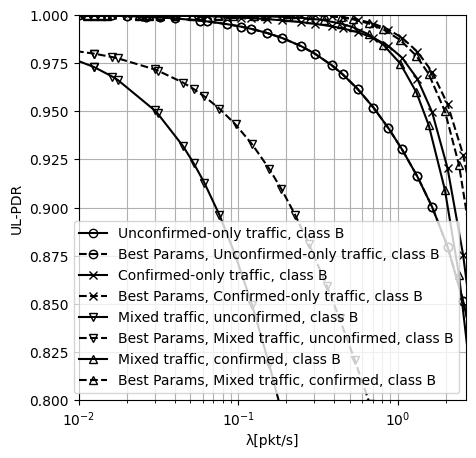

In [43]:
create_plot('final_sim/test_scenario_baseline/True/ULPDR_UNCONFIRMED_B', 'Unconfirmed-only traffic, class B','unc',7,'-','o')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_UNCONFIRMED_B', 'Best Params, Unconfirmed-only traffic, class B','unc',7,'--','o')

create_plot('final_sim/test_scenario_baseline/True/ULPDR_CONFIRMED_B', 'Confirmed-only traffic, class B','unc',7,'-','x')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_CONFIRMED_B_ULPDR', 'Best Params, Confirmed-only traffic, class B','unc',7,'--','x')

create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_B', 'Mixed traffic, unconfirmed, class B','m_unc',5,'-','v')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_MIXED_B_ULPDR', 'Best Params, Mixed traffic, unconfirmed, class B','m_unc',5,'--','v')

create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_B', 'Mixed traffic, confirmed, class B','m_c',5,'-','^')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_MIXED_B_ULPDR', 'Best Params, Mixed traffic, confirmed, class B','m_c',5,'--','^')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,2.7])
plt.ylim([0.8,1])

plt.grid(True, which='both')

# plt.savefig('svg_plots/class_b_baseline_ulpdr.svg', format='svg')
lines = plt.gca().get_lines()
print_percentage_diff(lines[0], lines[1])
print_percentage_diff(lines[2], lines[3])
print_percentage_diff(lines[4], lines[5])
print_percentage_diff(lines[6], lines[7])

plt.show()

<h3>UL-PDR Class C, Baseline Vs Best Params</h3>


 Line2D(Unconfirmed-only traffic, Baseline, class C)  Vs  Line2D(Unconfirmed-only traffic, Best Params, class C)
Data point for lowest percentage change (-0.031827504077770234%): x=6.03375, y1=0.6900718169550824, y2=0.6898521843194014
Data point for highest percentage change (0.05660441113500751%): x=3.9675, y1=0.7835705830684465, y2=0.7840141185828196
Average percentage gain/loss of Line2D(Unconfirmed-only traffic, Best Params, class C) compared to Line2D(Unconfirmed-only traffic, Baseline, class C): 0.0012580460330806071%

 Line2D(Confirmed-only traffic, Baseline ,class C)  Vs  Line2D(Confirmed-only traffic, Best Params, class C)
Data point for lowest percentage change (-0.13862616271913383%): x=0.10375, y1=1.0001493099967793, y2=0.9987628413868689
Data point for highest percentage change (26.505152168933332%): x=6.81375, y1=0.46944354497259533, y2=0.5938702709148167
Average percentage gain/loss of Line2D(Confirmed-only traffic, Best Params, class C) compared to Line2D(Confirmed-onl

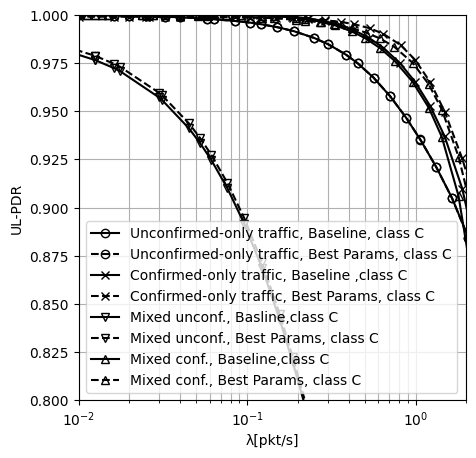

In [44]:
create_plot('final_sim/test_scenario_baseline/True/ULPDR_UNCONFIRMED_C', 'Unconfirmed-only traffic, Baseline, class C','unc',7,'-','o')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_UNCONFIRMED_C', 'Unconfirmed-only traffic, Best Params, class C','unc',7,'--','o')

create_plot('final_sim/test_scenario_baseline/True/ULPDR_CONFIRMED_C', 'Confirmed-only traffic, Baseline ,class C','unc',7,'-','x')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_CONFIRMED_C', 'Confirmed-only traffic, Best Params, class C','unc',7,'--','x')

create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_C', 'Mixed unconf., Basline,class C','m_unc',5,'-','v')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_MIXED_C_ULPDR', 'Mixed unconf., Best Params, class C','m_unc',5,'--','v')

create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_C', 'Mixed conf., Baseline,class C','m_c',5,'-','^')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_MIXED_C_ULPDR', 'Mixed conf., Best Params, class C','m_c',5,'--','^')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,2])
plt.ylim([0.8,1])

plt.grid(True, which='both')
lines = plt.gca().get_lines()
print_percentage_diff(lines[0], lines[1])
print_percentage_diff(lines[2], lines[3])
print_percentage_diff(lines[4], lines[5])
print_percentage_diff(lines[6], lines[7])
# plt.savefig('svg_plots/class_b_baseline_ulpdr.svg', format='svg')
plt.show()

<h3>CPSR Class B, Class C, Baseline Vs Best Params</h3>


 Line2D(Conf., Baseline, class B)  Vs  Line2D(Conf., Best Params, class B)
Data point for lowest percentage change (-4.282783955775446%): x=6.03, y1=0.05339179435491581, y2=0.05110513915258286
Data point for highest percentage change (8.30684528113745%): x=4.9025, y1=0.07803405657743312, y2=0.08451622492391575
Average percentage gain/loss of Line2D(Conf., Best Params, class B) compared to Line2D(Conf., Baseline, class B): 0.6224656111538256%

 Line2D(Mixed conf., Baseline, class B)  Vs  Line2D(Mixed conf., Best Params, class B)
Data point for lowest percentage change (-2.5274197658103743%): x=1.3125, y1=0.25487697285929967, y2=0.24843516186875458
Data point for highest percentage change (13.479219988607975%): x=3.7575, y1=0.07903958276092593, y2=0.089693501999349
Average percentage gain/loss of Line2D(Mixed conf., Best Params, class B) compared to Line2D(Mixed conf., Baseline, class B): 0.46600188084335786%


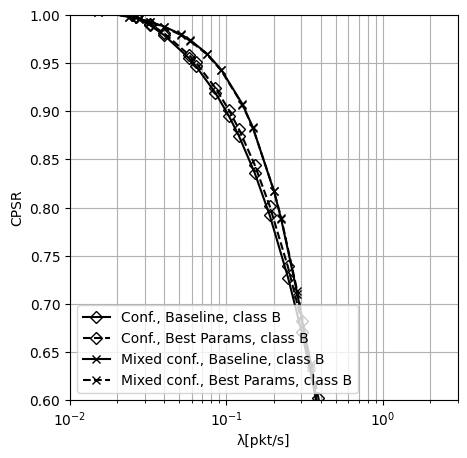


 Line2D(Conf., Baseline, class C)  Vs  Line2D(Conf., Best Params, class C)
Data point for lowest percentage change (-0.3622513019141889%): x=0.0025, y1=1.0261186335210741, y2=1.02240150541196
Data point for highest percentage change (29.385176018244668%): x=2.8925, y1=0.07629557511691032, y2=0.0987151641591465
Average percentage gain/loss of Line2D(Conf., Best Params, class C) compared to Line2D(Conf., Baseline, class C): 7.720880800613925%

 Line2D(Mixed conf., Baseline, class C)  Vs  Line2D(Mixed conf., Best Params, class C)
Data point for lowest percentage change (-0.31993127104953695%): x=0.0025, y1=1.0087500991923655, y2=1.0055227921783059
Data point for highest percentage change (34.35210982875698%): x=1.7975, y1=0.10423098375789963, y2=0.14003652577400716
Average percentage gain/loss of Line2D(Mixed conf., Best Params, class C) compared to Line2D(Mixed conf., Baseline, class C): 7.245602446684828%


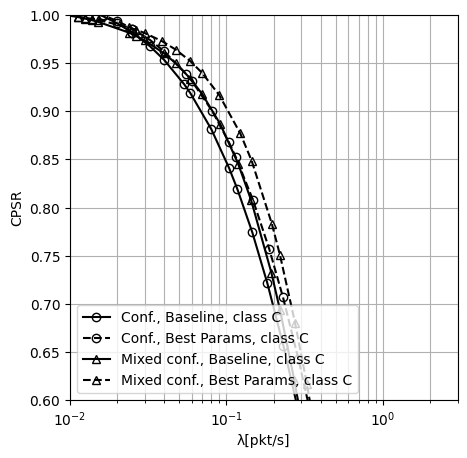

In [46]:
#final_sim/test_scenario_best_params/on/
create_plot('final_sim/test_scenario_baseline/True/ULPDR_CONFIRMED_B', 'Conf., Baseline, class B','cpsr',7,'-','D')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_CONFIRMED_B_CPSR', 'Conf., Best Params, class B','cpsr',7,'--','D')


create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_B', 'Mixed conf., Baseline, class B','cpsr',7,'-','x')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_MIXED_B_CPSR', 'Mixed conf., Best Params, class B','cpsr',7,'--','x')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,3])
plt.ylim([0.6,1.0])


lines = plt.gca().get_lines()
print_percentage_diff(lines[0], lines[1])
print_percentage_diff(lines[2], lines[3])


plt.grid(True, which='both')
# plt.savefig('svg_plots/class_b_c_gw_tx_priority_cpsr.svg', format='svg')
plt.show()

create_plot('final_sim/test_scenario_baseline/True/ULPDR_CONFIRMED_C', 'Conf., Baseline, class C','cpsr',7,'-','o')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_CONFIRMED_C', 'Conf., Best Params, class C','cpsr',7,'--','o')


create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_C', 'Mixed conf., Baseline, class C','cpsr',7,'-','^')
create_plot('final_sim/test_scenario_best_params/on/ULPDR_MIXED_C_CPSR', 'Mixed conf., Best Params, class C','cpsr',7,'--','^')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,3])
plt.ylim([0.6,1.0])

lines = plt.gca().get_lines()
print_percentage_diff(lines[0], lines[1])
print_percentage_diff(lines[2], lines[3])

plt.grid(True, which='both')
# plt.savefig('svg_plots/class_b_c_gw_tx_priority_cpsr.svg', format='svg')
plt.show()